In [2]:
import os
import pybedtools
import pandas as pd
import numpy as np
import glob
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
#import pybedtools
import random
from Bio import SeqIO
from Bio.Seq import Seq
import pysam

This notebook incorporates Genes and Transcripts with 0 edits and LM to get signal over background

In [3]:
custom_palette = ['#C8ADC0', '#FE9920', '#028090', '#151E3F', '#7E1F86','#F27D18']

In [4]:
sns_palette = sns.color_palette(custom_palette)

In [5]:
sns_palette

[(0.7843137254901961, 0.6784313725490196, 0.7529411764705882),
 (0.996078431372549, 0.6, 0.12549019607843137),
 (0.00784313725490196, 0.5019607843137255, 0.5647058823529412),
 (0.08235294117647059, 0.11764705882352941, 0.24705882352941178),
 (0.49411764705882355, 0.12156862745098039, 0.5254901960784314),
 (0.9490196078431372, 0.49019607843137253, 0.09411764705882353)]

In [6]:
sns.set_palette(sns_palette)

In [7]:
working_dir = '/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline'

In [7]:
fig_path = '/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/notebooks/figs/'

In [8]:
sample_dict_apo = {'rep1' : 'APO1_1', 
               'rep2' : 'APO1_2',
               'rep3' : 'APO1_3',}
sample_dict_rps2 = {'rep1' : 'RPS2_1', 
               'rep2' : 'RPS2_2',
               'rep3' : 'RPS2_3',}

In [9]:
output_dir = '/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline'

In [10]:
gtf_file = '/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/refs/hg19/gencode.v19.annotation.gtf'  # Replace with your GTF file path

In [11]:
total_mapped_reads = {}
for keys in ['rep1', 'rep2', 'rep3']:
    total_mapped_reads[sample_dict_rps2[keys]] = int(pysam.view("-c", os.path.join(working_dir, f'{sample_dict_rps2[keys]}/input_dir/{sample_dict_rps2[keys]}.flnc.aligned.readfiltered.sorted.bam')).strip('\n'))
    total_mapped_reads[sample_dict_apo[keys]] = int(pysam.view("-c", os.path.join(working_dir, f'{sample_dict_apo[keys]}/input_dir/{sample_dict_apo[keys]}.flnc.aligned.readfiltered.sorted.bam')).strip('\n'))

In [16]:
## Store gene characteristics in dictionaries
gtf_len_df = pd.read_csv(gtf_file, sep='\t', header=None, comment='#') 
gtf_len_df = gtf_len_df[gtf_len_df[2] == 'gene'] # Filter rows with the "gene" feature
gtf_len_df['gene_length'] = gtf_len_df[4] - gtf_len_df[3] + 1 # Calculate gene lengths
gtf_len_df['gene_id'] = gtf_len_df[8].str.extract('gene_id "([^"]+)"') # extract gene id
gene_length_dict = gtf_len_df.set_index('gene_id')['gene_length'].to_dict() # Create a dictionary with gene id as keys and gene lengths as values
gtf_len_df['gene_name'] = gtf_len_df[8].str.extract('gene_name "([^"]+)"') # extract gene name
gene_name_length_dict = gtf_len_df.set_index('gene_name')['gene_length'].to_dict() # Create dictionary with gene names as keys and gene name as keys and gene length as values
gene_id_to_name_dict = gtf_len_df.set_index('gene_id')['gene_name'].to_dict() # Create dictionary with gene id as keys and gene name as values

In [17]:
## Store mRNA isoform characteristics in dictionaries

gtf_transcript_to_gene_df = pd.read_csv(gtf_file, sep='\t', header=None, comment='#')
gtf_transcript_to_gene_df = gtf_transcript_to_gene_df[gtf_transcript_to_gene_df[2] == 'transcript']
gtf_transcript_to_gene_df['gene_id'] = gtf_transcript_to_gene_df[8].str.extract('gene_id "([^"]+)"')
gtf_transcript_to_gene_df['transcript_id'] = gtf_transcript_to_gene_df[8].str.extract('transcript_id "([^"]+)"')
gtf_transcript_to_gene_df['transcript_length'] = gtf_transcript_to_gene_df[4] - gtf_transcript_to_gene_df[3]
gtf_transcript_to_gene_dict = dict(zip(gtf_transcript_to_gene_df.transcript_id, gtf_transcript_to_gene_df.gene_id))
gtf_transcript_to_length_dict = dict(zip(gtf_transcript_to_gene_df.transcript_id, gtf_transcript_to_gene_df.transcript_length))

In [21]:
# Store mRNA isoform counts data in a dictionary

transcript_counts={}
for rep in ['rep1', 'rep2', 'rep3']:
    for sample_dict in [sample_dict_apo, sample_dict_rps2]:
        transcript_counts_table = pd.read_csv(f'/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/{sample_dict[rep]}/output_dir/{sample_dict[rep]}_isoquant/{sample_dict[rep]}/{sample_dict[rep]}.transcript_counts.tsv', comment='#', sep='\t', header=None)
        transcript_counts_table = transcript_counts_table.rename(columns={0:'transcript_id', 1: f'{sample_dict[rep]}_count'})
        transcript_counts_table['Length'] = transcript_counts_table.transcript_id.map(gtf_transcript_to_length_dict)
        transcript_counts_table = transcript_counts_table[transcript_counts_table[f'{sample_dict[rep]}_count'] >=20]
        transcript_counts_table[f'{sample_dict[rep]}_RPKM'] = transcript_counts_table.apply(lambda x: (x[f'{sample_dict[rep]}_count'])/((transcript_counts_table[f'{sample_dict[rep]}_count'].sum()/1000000.)*(x['Length']/1000.)), axis=1)
        transcript_counts[f'{sample_dict[rep]}'] = transcript_counts_table.set_index('transcript_id')

In [22]:
# Store gene-level counts data in a dictionary

gene_counts = {}
for key in transcript_counts:
    gene_count_df=transcript_counts[key].copy()
    gene_count_df['gene_id'] = gene_count_df.index.map(gtf_transcript_to_gene_dict)
    gene_count_df = gene_count_df[[f'{key}_count', 'gene_id']].groupby('gene_id').sum()
    gene_count_df = gene_count_df.rename(columns={f'{key}_count' : f'{key}'})
    gene_count_df['Length'] = gene_count_df.index.map(gene_length_dict)
    gene_count_df[f'{key}_RPKM'] = gene_count_df.apply(lambda x: (x[f'{key}'])/((gene_count_df[f'{key}'].sum()/1000000.)*(x['Length']/1000.)), axis=1)
    gene_count_df = gene_count_df[gene_count_df[key] >=20]
    gene_count_df = gene_count_df.reset_index().rename(columns={'gene_id' : 'Geneid'})
    gene_counts[key] = gene_count_df

## Concatenate and filter edits for all samples and replicates 

#### Get Read Level Edits

In [23]:
def concat_splits_all_edits(sample_dict):
    '''concatenate all position level edits from all splits and reps and store as dictionary'''
    concat_edits = {}
    for key in sample_dict:
        print(key)
        read_level_edits_df = pd.DataFrame()
        empty_splits = []
        for p in tqdm.tqdm(glob.glob(os.path.join(working_dir, f'{sample_dict[key]}/output_dir/read_level_edits_ct/*edits_*.bed'))):
            if os.path.getsize(p) != 0:
                edit_df = pd.read_csv(p, sep='\t', header=None)
                edit_df['split_label'] =  p.split('/')[-1].split('_read_level_edits')[0]
                edit_df['key'] = edit_df.apply(lambda x: f'{x[0]}:{str(x[1])}:{str(x[2])}', axis=1)
                edit_df['location'] = p.split('/')[-1].split('.bed')[0].split('edits_')[-1]
                edit_df = edit_df[edit_df['location']=='CDS'] #### ONLY KEEPING CDS
                read_level_edits_df = pd.concat([read_level_edits_df, edit_df])
            else:
                empty_splits.append(p.split('/')[-1])
        
        print(' '.join(empty_splits))
        concat_edits[key] = read_level_edits_df
        
    return concat_edits

In [24]:
concat_edits_apo = concat_splits_all_edits(sample_dict_apo)

rep1


100%|██████████| 426/426 [00:04<00:00, 91.44it/s] 


split_bam_1_82_read_level_edits_5utr.bed split_bam_1_81_read_level_edits_5utr.bed split_bam_7_0_read_level_edits_CDS.bed split_bam_9_0_read_level_edits_5utr.bed split_bam_10_0_read_level_edits_5utr.bed split_bam_7_0_read_level_edits_5utr.bed split_bam_10_0_read_level_edits_3utr.bed split_bam_2_24_read_level_edits_5utr.bed split_bam_8_0_read_level_edits_5utr.bed split_bam_10_0_read_level_edits_CDS.bed
rep2


100%|██████████| 411/411 [00:03<00:00, 105.11it/s]


split_bam_2_21_read_level_edits_5utr.bed split_bam_11_0_read_level_edits_5utr.bed split_bam_1_82_read_level_edits_5utr.bed split_bam_7_0_read_level_edits_CDS.bed split_bam_11_0_read_level_edits_3utr.bed split_bam_9_0_read_level_edits_CDS.bed split_bam_10_0_read_level_edits_5utr.bed split_bam_2_23_read_level_edits_5utr.bed split_bam_7_0_read_level_edits_5utr.bed split_bam_9_0_read_level_edits_3utr.bed split_bam_10_0_read_level_edits_3utr.bed split_bam_2_26_read_level_edits_5utr.bed split_bam_7_0_read_level_edits_3utr.bed split_bam_8_0_read_level_edits_5utr.bed split_bam_10_0_read_level_edits_CDS.bed split_bam_11_0_read_level_edits_CDS.bed
rep3


100%|██████████| 420/420 [00:04<00:00, 93.69it/s] 

split_bam_1_81_read_level_edits_5utr.bed split_bam_3_7_read_level_edits_5utr.bed split_bam_1_71_read_level_edits_5utr.bed split_bam_8_0_read_level_edits_3utr.bed split_bam_2_19_read_level_edits_5utr.bed split_bam_10_0_read_level_edits_5utr.bed split_bam_1_86_read_level_edits_5utr.bed split_bam_7_0_read_level_edits_5utr.bed split_bam_1_80_read_level_edits_5utr.bed split_bam_3_5_read_level_edits_5utr.bed split_bam_1_83_read_level_edits_5utr.bed split_bam_10_0_read_level_edits_3utr.bed split_bam_1_91_read_level_edits_5utr.bed split_bam_8_0_read_level_edits_5utr.bed split_bam_10_0_read_level_edits_CDS.bed split_bam_1_89_read_level_edits_5utr.bed


In [25]:
concat_edits_rps2 = concat_splits_all_edits(sample_dict_rps2)

rep1


100%|██████████| 390/390 [00:13<00:00, 28.41it/s]


split_bam_11_0_read_level_edits_5utr.bed split_bam_11_0_read_level_edits_3utr.bed split_bam_9_0_read_level_edits_5utr.bed split_bam_10_0_read_level_edits_5utr.bed split_bam_7_0_read_level_edits_5utr.bed split_bam_9_0_read_level_edits_3utr.bed split_bam_10_0_read_level_edits_3utr.bed split_bam_8_0_read_level_edits_5utr.bed
rep2


100%|██████████| 387/387 [00:07<00:00, 52.02it/s]


split_bam_11_0_read_level_edits_5utr.bed split_bam_11_0_read_level_edits_3utr.bed split_bam_10_0_read_level_edits_5utr.bed split_bam_7_0_read_level_edits_5utr.bed split_bam_1_75_read_level_edits_5utr.bed split_bam_7_0_read_level_edits_3utr.bed split_bam_8_0_read_level_edits_5utr.bed
rep3


100%|██████████| 429/429 [00:07<00:00, 57.41it/s]

split_bam_9_0_read_level_edits_5utr.bed split_bam_10_0_read_level_edits_5utr.bed split_bam_7_0_read_level_edits_5utr.bed split_bam_10_0_read_level_edits_3utr.bed split_bam_8_0_read_level_edits_5utr.bed


#### Get position level edits

In [26]:
def concat_splits_all_pos_edits(sample_dict):
    all_sample_pos_edits = {}
    for key in sample_dict:
        print(key)
        all_pos_edits_df = pd.DataFrame()
        empty_splits = []
        bed_files = [i for i in glob.glob(os.path.join(working_dir, f'{sample_dict[key]}/output_dir/*_ct_*.bed')) if '_transcript' not in i]
        for p in tqdm.tqdm(bed_files):
            if '_transcript' not in p:
                if os.path.getsize(p) != 0:
                    split_pos_edit_df = pd.read_csv(p, sep='\t', header=None)
                    split_pos_edit_df['split_label'] =  p.split('/')[-1].split('_ct_')[0]
                    split_pos_edit_df['key'] = split_pos_edit_df.apply(lambda x: f'{x[0]}:{str(x[1])}:{str(x[2])}', axis=1)
                    split_pos_edit_df['location'] = p.split('/')[-1].split('.bed')[0].split('_ct_')[-1]
                    split_pos_edit_df['conversion'] = split_pos_edit_df.apply(lambda x: int(x[4].split(',')[0]), axis=1)
                    split_pos_edit_df['coverage'] = split_pos_edit_df.apply(lambda x: int(x[4].split(',')[1]), axis=1)
                    split_pos_edit_df['edit_fraction'] = split_pos_edit_df.apply(lambda x: x['conversion']/x['coverage'], axis=1)
                    split_pos_edit_df = split_pos_edit_df[split_pos_edit_df['location']=='CDS']#### ONLY KEEPING CDS EDITS
                    all_pos_edits_df = pd.concat([all_pos_edits_df, split_pos_edit_df])
                else:
                    empty_splits.append(p.split('/')[-1])

        print(' '.join(empty_splits))
        all_sample_pos_edits[key] = all_pos_edits_df
        
    return all_sample_pos_edits

In [27]:
all_pos_edits_apo = concat_splits_all_pos_edits(sample_dict_apo)

rep1


100%|██████████| 426/426 [00:04<00:00, 95.91it/s] 


split_bam_10_0_ct_CDS.bed split_bam_1_81_ct_5utr.bed split_bam_10_0_ct_3utr.bed split_bam_10_0_ct_5utr.bed split_bam_1_82_ct_5utr.bed split_bam_2_24_ct_5utr.bed split_bam_7_0_ct_CDS.bed split_bam_8_0_ct_5utr.bed split_bam_7_0_ct_5utr.bed split_bam_9_0_ct_5utr.bed
rep2


100%|██████████| 408/408 [00:04<00:00, 95.15it/s] 


split_bam_10_0_ct_CDS.bed split_bam_7_0_ct_3utr.bed split_bam_10_0_ct_3utr.bed split_bam_2_23_ct_5utr.bed split_bam_10_0_ct_5utr.bed split_bam_9_0_ct_CDS.bed split_bam_1_82_ct_5utr.bed split_bam_2_26_ct_5utr.bed split_bam_7_0_ct_CDS.bed split_bam_9_0_ct_3utr.bed split_bam_8_0_ct_5utr.bed split_bam_2_21_ct_5utr.bed split_bam_7_0_ct_5utr.bed
rep3


100%|██████████| 420/420 [00:04<00:00, 104.59it/s]

split_bam_10_0_ct_CDS.bed split_bam_1_91_ct_5utr.bed split_bam_1_81_ct_5utr.bed split_bam_1_89_ct_5utr.bed split_bam_1_86_ct_5utr.bed split_bam_10_0_ct_3utr.bed split_bam_3_5_ct_5utr.bed split_bam_1_80_ct_5utr.bed split_bam_1_83_ct_5utr.bed split_bam_3_7_ct_5utr.bed split_bam_10_0_ct_5utr.bed split_bam_1_71_ct_5utr.bed split_bam_8_0_ct_3utr.bed split_bam_2_19_ct_5utr.bed split_bam_8_0_ct_5utr.bed split_bam_7_0_ct_5utr.bed


In [28]:
all_pos_edits_rps2 = concat_splits_all_pos_edits(sample_dict_rps2)

rep1


100%|██████████| 390/390 [00:10<00:00, 38.36it/s]


split_bam_10_0_ct_3utr.bed split_bam_10_0_ct_5utr.bed split_bam_11_0_ct_5utr.bed split_bam_9_0_ct_3utr.bed split_bam_8_0_ct_5utr.bed split_bam_11_0_ct_3utr.bed split_bam_7_0_ct_5utr.bed split_bam_9_0_ct_5utr.bed
rep2


100%|██████████| 387/387 [00:07<00:00, 48.53it/s]


split_bam_7_0_ct_3utr.bed split_bam_1_75_ct_5utr.bed split_bam_10_0_ct_5utr.bed split_bam_11_0_ct_5utr.bed split_bam_8_0_ct_5utr.bed split_bam_11_0_ct_3utr.bed split_bam_7_0_ct_5utr.bed
rep3


100%|██████████| 428/428 [00:10<00:00, 40.28it/s]

split_bam_10_0_ct_5utr.bed split_bam_8_0_ct_5utr.bed split_bam_7_0_ct_5utr.bed split_bam_9_0_ct_5utr.bed


In [34]:
# sites common to all replicates of APOBEC1-only
common_apo_sites = set(all_pos_edits_apo['rep1']['key'].tolist()).intersection(set(all_pos_edits_apo['rep2']['key'].tolist()).intersection(set(all_pos_edits_apo['rep3']['key'].tolist())))

In [35]:
# sites common to all replicates of Ribo-STAMP
common_rps2_sites = set(all_pos_edits_rps2['rep1']['key'].tolist()).intersection(set(all_pos_edits_rps2['rep2']['key'].tolist()).intersection(set(all_pos_edits_rps2['rep3']['key'].tolist())))

In [36]:
# sites common across all replicates of APOBEC1-only and Ribo-STAMP
common_rps2_apo_sites = common_rps2_sites.intersection(common_apo_sites)

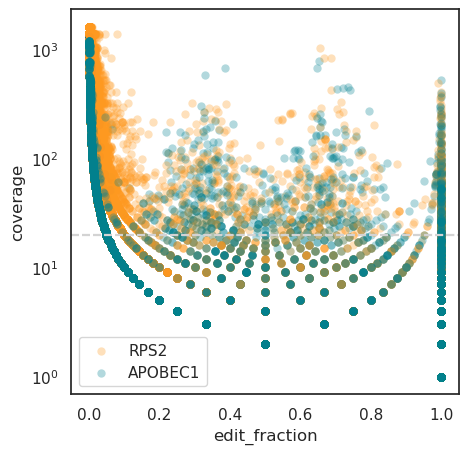

In [38]:
# Coverage vs. edit fraction relationship for all edited sites in APOBEC1-only (green) samples and Ribo-STAMP samples (gold)
sns.set(rc={'figure.figsize':(5,5)})
sns.set_style('white')

for rep in ['rep1', 'rep2', 'rep3']:
    sns.scatterplot(data=all_pos_edits_rps2[rep], x='edit_fraction', y='coverage', alpha=0.3, linewidth=0, color='#FE9920')
    sns.scatterplot(data=all_pos_edits_apo[rep], x='edit_fraction', y='coverage', alpha=0.3, linewidth=0, color='#028090')
    plt.yscale('log')
    plt.legend(['RPS2', 'APOBEC1'])
    plt.axhline(y=20, color='lightgrey', linestyle='dashed')
plt.show()

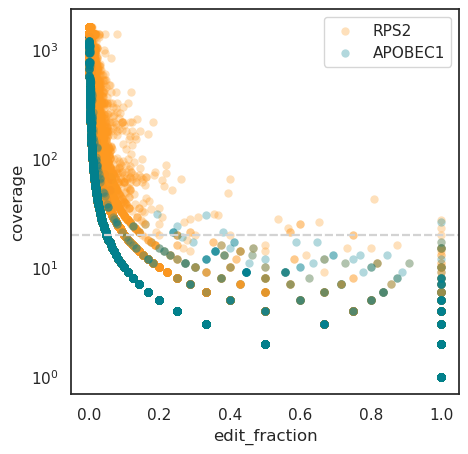

In [39]:
# Coverage vs. edit fraction relationship for all edited sites in APOBEC1-only (green) samples and Ribo-STAMP samples (gold) with common sites removed
for rep in ['rep1', 'rep2', 'rep3']:
    sns.scatterplot(data=all_pos_edits_rps2[rep][~all_pos_edits_rps2[rep]['key'].isin(common_rps2_apo_sites)], x='edit_fraction', y='coverage', alpha=0.3, linewidth=0, color='#FE9920')
    sns.scatterplot(data=all_pos_edits_apo[rep][~all_pos_edits_apo[rep]['key'].isin(common_rps2_apo_sites)], x='edit_fraction', y='coverage', alpha=0.3, linewidth=0, color='#028090')
    
    plt.yscale('log')
    plt.legend(['RPS2', 'APOBEC1'])
    plt.axhline(y=20, color='lightgrey', linestyle='dashed')
plt.show()

In [40]:
# storing edits after removing edited sites found across all replicates of APOBEC1-only and Ribo-STAMP samples
all_pos_edits_apo_common_removed = {}
all_pos_edits_rps2_common_removed = {}
for rep in ['rep1', 'rep2', 'rep3']:
    all_pos_edits_apo_common_removed[rep] = all_pos_edits_apo[rep][~all_pos_edits_apo[rep]['key'].isin(common_rps2_apo_sites)]
    all_pos_edits_rps2_common_removed[rep] = all_pos_edits_rps2[rep][~all_pos_edits_rps2[rep]['key'].isin(common_rps2_apo_sites)]

In [48]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2,venn3

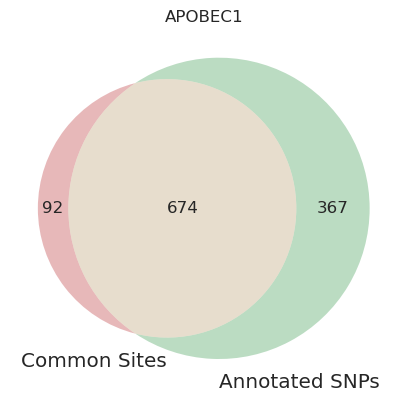

In [49]:
# Overlap between APOBEC1-only sites found across all replicates of APOBEC1-only and Ribo-STAMP and annotated SNPs

set1_apobec = set(all_pos_edits_apo[rep][all_pos_edits_apo[rep]['key'].isin(common_rps2_apo_sites)]['key'].tolist())
set2_apobec = set(all_pos_edits_apo[rep][all_pos_edits_apo[rep]['key'].isin(snps_list)]['key'].tolist())

venn2([set1_apobec, set2_apobec], ('Common Sites', 'Annotated SNPs'))
plt.title('APOBEC1')
plt.show()

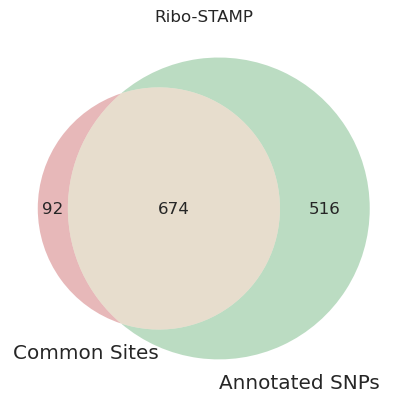

In [50]:
# Overlap between Ribo-STAMP sites found across all replicates of APOBEC1-only and Ribo-STAMP and annotated SNPs

set1_ribostamp = set(all_pos_edits_rps2[rep][all_pos_edits_rps2[rep]['key'].isin(common_rps2_apo_sites)]['key'].tolist())
set2_ribostamp = set(all_pos_edits_rps2[rep][all_pos_edits_rps2[rep]['key'].isin(snps_list)]['key'].tolist())

venn2([set1_ribostamp, set2_ribostamp], ('Common Sites', 'Annotated SNPs'))
plt.title('Ribo-STAMP')
plt.show()

In [43]:
# loading annotated SNPs
snps = pd.read_csv('/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/refs/hg19/hg19.commonSNPs147.bed3', sep='\t', header=None)

In [44]:
snps['key'] = snps.apply(lambda x: f'{x[0]}:{str(x[1])}:{str(x[2])}', axis=1)
snps['length'] = snps[2] - snps[1]
snps_list = snps['key'].tolist()

In [45]:
snps.head()

,0,1,2,key,length
0,chr1,40370176,40370176,chr1:40370176:40370176,0
1,chr1,61341695,61341699,chr1:61341695:61341699,4
2,chr1,180879355,180879367,chr1:180879355:180879367,12
3,chr1,10177,10177,chr1:10177:10177,0
4,chr1,10352,10352,chr1:10352:10352,0


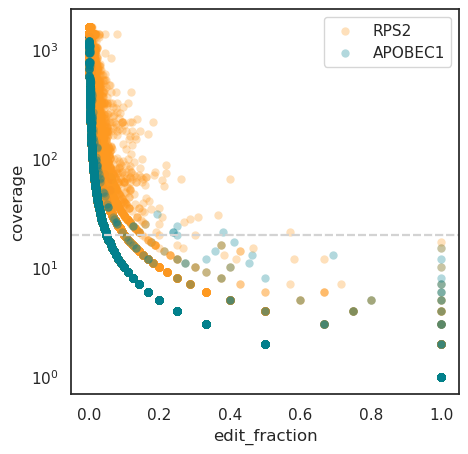

In [46]:
# Coverage vs. edit fraction relationship for all edited sites in APOBEC1-only (green) samples and Ribo-STAMP samples (gold) with common sites and annotated SNPs removed
for rep in ['rep1', 'rep2', 'rep3']:
    sns.scatterplot(data=all_pos_edits_rps2_common_removed[rep][~all_pos_edits_rps2_common_removed[rep]['key'].isin(snps_list)], x='edit_fraction', y='coverage', alpha=0.3, linewidth=0, color='#FE9920')
    sns.scatterplot(data=all_pos_edits_apo_common_removed[rep][~all_pos_edits_apo_common_removed[rep]['key'].isin(snps_list)], x='edit_fraction', y='coverage', alpha=0.3, linewidth=0, color='#028090')
    
    plt.yscale('log')
    plt.legend(['RPS2', 'APOBEC1'])
    plt.axhline(y=20, color='lightgrey', linestyle='dashed')
plt.show()

In [51]:
# storing edits after removing edited sites found across all replicates of APOBEC1-only and Ribo-STAMP samples and annotated SNPs
all_pos_edits_apo_common_all_rps2_snp_removed = {}
all_pos_edits_rps2_common_all_rps2_snp_removed = {}
for rep in ['rep1', 'rep2', 'rep3']:
    all_pos_edits_apo_common_all_rps2_snp_removed[rep] = all_pos_edits_apo_common_removed[rep][~all_pos_edits_apo_common_removed[rep]['key'].isin(snps_list)]
    all_pos_edits_rps2_common_all_rps2_snp_removed[rep] = all_pos_edits_rps2_common_removed[rep][~all_pos_edits_rps2_common_removed[rep]['key'].isin(snps_list)]

In [52]:
# Final edits to keep for APOBEC1-only samples
keep_edits_apo = {}
for rep in ['rep1', 'rep2', 'rep3']:
    df_apo = all_pos_edits_apo_common_all_rps2_snp_removed[rep].copy()
    df_apo['gene_id'] = df_apo.apply(lambda x: x[3].split(':')[0], axis=1)
    df_apo['transcript_id'] = df_apo.apply(lambda x: x[3].split(':')[1], axis=1)
    keep_edits_apo[rep] = df_apo

In [53]:
# Final edits to keep for Ribo-STAMP samples

keep_edits_rps2 = {}
for rep in ['rep1', 'rep2', 'rep3']:
    df_rps2 = all_pos_edits_rps2_common_all_rps2_snp_removed[rep].copy()
    df_rps2['gene_id'] = df_rps2.apply(lambda x: x[3].split(':')[0], axis=1)
    df_rps2['transcript_id'] = df_rps2.apply(lambda x: x[3].split(':')[1], axis=1)
    keep_edits_rps2[rep] = df_rps2

/tscc/projects/ps-yeolab3/pjaganna1/STAMP/github_repos/LR-Ribo-STAMP/publication_notebooks/APOBEC1-only_Ribo-STAMP_HEK293T/ipykernel_2183968/149044730.py:16: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.barplot(data=mapped_edits_df, x='sample', y='counts', hue='metric', palette=custom_palette[2:])


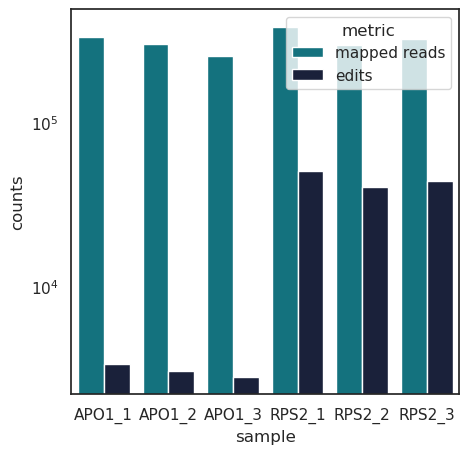

In [55]:
# plotting mapped reads and edits for each sample 

mapped_edits = []
for sample_dict in [['apo', sample_dict_apo], ['rps2',sample_dict_rps2]]:
    s = sample_dict[0]
    d = sample_dict[1]
    for r in ['rep1', 'rep2', 'rep3']:
        if s=='apo':
            mapped_edits.append([d[r], total_mapped_reads[d[r]], 'mapped reads'])
            mapped_edits.append([d[r], keep_edits_apo[r].shape[0], 'edits'])
        elif s=='rps2':
            mapped_edits.append([d[r], total_mapped_reads[d[r]], 'mapped reads'])
            mapped_edits.append([d[r], keep_edits_rps2[r].shape[0], 'edits'])
                                
mapped_edits_df = pd.DataFrame(mapped_edits, columns=['sample', 'counts', 'metric'])
sns.barplot(data=mapped_edits_df, x='sample', y='counts', hue='metric', palette=custom_palette[2:])
plt.yscale('log')

## Calculate EditsC


### Getting Exon and UTRs for Gene and Isoform (Don't need to re-run unless creating files again')

In [74]:
def gtf_to_bed(gtf_file, bed_file):
    '''generate BED file for exons and UTRs of genes'''
    
    gtf_df = pd.read_csv(gtf_file, sep='\t', comment='#', header=None,
                     names=['chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute']) # GTF columns: chromosome, source, feature, start, end, score, strand, frame, attribute
    gtf_df = gtf_df[gtf_df['feature'].isin(['exon', 'UTR'])] # Filter for exons and UTRs
    gtf_df['gene_name'] = gtf_df['attribute'].str.extract('gene_id "([^"]+)"') # Extract gene name from the attribute field
    bed_df = gtf_df[['chrom', 'start', 'end', 'gene_name', 'score', 'strand']] # Create a BED formatted DataFrame
    bed_df['start'] = bed_df['start'] - 1 # Adjust start position for BED format (0-based start, GTF is 1-based)
    bed_df.to_csv(bed_file, sep='\t', index=False, header=False) # Write to BED file

In [75]:
gtf_file = '/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/refs/hg19/gencode.v19.annotation.gtf'  # Replace with your GTF file path
bed_file = '/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/refs/hg19/output_exons_utrs.bed'
#gtf_to_bed(gtf_file, bed_file) # only run once

In commandline:

```sort -k1,1 -k2,2n output_exons_utrs.bed > output_exons_utrs.sorted.bed```

```bedtools merge -i output_exons_utrs.genes.sorted.bed -s -c 4,6 -o distinct > merged_exons_utrs.genes.hg19.bed``` 

```bedtools getfasta -fi hg19.fa -bed merged_exons_utrs.genes.hg19.bed -name -s > merged_exons_utrs.genes.hg19.fasta```

In [76]:
def count_cytosines(fasta_file):
    '''Count the cytosines for coordinate groups associated with each gene'''
    cytosine_counts = {}
    for record in SeqIO.parse(fasta_file, "fasta"):
        gene_ids = record.id.split(":")[0].split(',')  # Adjust based on your FASTA header format
        sequence = str(record.seq).upper()
        for gene_id in gene_ids:
            if gene_id in cytosine_counts:
                cytosine_counts[gene_id] += sequence.count('C')
            else:
                cytosine_counts[gene_id] = sequence.count('C')
    return cytosine_counts

In [77]:
gene_coordinates_fasta = '/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/refs/hg19/merged_exons_utrs.genes.hg19.fasta'

In [78]:
gene_cytosine_counts = count_cytosines(gene_coordinates_fasta)

In [79]:
def gtf_to_bed_transcript(gtf_file, bed_file):
    '''generate BED file for exons and UTRs of mRNA isoforms'''
    
    gtf_df = pd.read_csv(gtf_file, sep='\t', comment='#', header=None,
                     names=['chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute']) # GTF columns: chromosome, source, feature, start, end, score, strand, frame, attribute
    gtf_df = gtf_df[gtf_df['feature'].isin(['exon', 'UTR'])] # Filter for exons and UTRs
    gtf_df['transcript_id'] = gtf_df['attribute'].str.extract('transcript_id "([^"]+)"') # Extract gene name from the attribute field
    bed_df = gtf_df[['chrom', 'start', 'end', 'transcript_id', 'score', 'strand']] # Create a BED formatted DataFrame
    bed_df['start'] = bed_df['start'] - 1 # Adjust start position for BED format (0-based start, GTF is 1-based)
    bed_df.to_csv(bed_file, sep='\t', index=False, header=False) # Write to BED file

In [80]:
transcript_bed_file = '/tscc/nfs//home/pjaganna1/projects/STAMP/stamp_v3_pipeline/refs/hg19/output_exons_utrs.transcript.bed'
#gtf_to_bed_transcript(gtf_file, transcript_bed_file) # only run once

In commandline: 

```sort -k1,1 -k2,2n output_exons_utrs.transcript.bed > output_exons_utrs.transcript.sorted.bed```

```bedtools merge -i output_exons_utrs.transcript.sorted.bed -s -c 4,6 -o distinct > merged_exons_utrs.transcript.hg19.bed```

```bedtools getfasta -fi hg19.fa -bed merged_exons_utrs.transcript.hg19.bed -name -s > merged_exons_utrs.transcript.hg19.fasta```

In [81]:
def count_cytosines_transcript(fasta_file):
    '''Count the cytosines for coordinate groups associated with each mRNA isoform'''
    cytosine_counts = {}
    for record in SeqIO.parse(fasta_file, "fasta"):
        ids = record.id.split(":")[0].split(',')  # Adjust based on your FASTA header format
        sequence = str(record.seq).upper()
        for transcript in ids:
            if transcript in cytosine_counts:
                cytosine_counts[transcript] += sequence.count('C')
            else:
                cytosine_counts[transcript] = sequence.count('C')
    return cytosine_counts

In [82]:
transcript_coordinates_fasta = '/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/refs/hg19/merged_exons_utrs.transcript.hg19.fasta'

In [83]:
transcript_cytosine_counts = count_cytosines_transcript(transcript_coordinates_fasta)

In [84]:
def calculate_editsC(keep_edits, c_counts):
    '''Calculate the editsC metric for the gene level'''
    gene_editsC = {}
    for rep in ['rep1', 'rep2', 'rep3']:
        edit_count_gene = keep_edits[rep].drop_duplicates(subset=[0,1,2,5, 'gene_id']).groupby('gene_id').count()[[0]]
        edit_count_gene['num_c'] = edit_count_gene.index.map(c_counts)
        edit_count_gene = edit_count_gene.rename(columns={0:'edited_c'})
        edit_count_gene['editsC'] = edit_count_gene['edited_c']/edit_count_gene['num_c']
        gene_editsC[rep] = edit_count_gene
    return gene_editsC

In [85]:
apo_gene_editsC = calculate_editsC(keep_edits_apo, gene_cytosine_counts)

In [86]:
rps2_gene_editsC = calculate_editsC(keep_edits_rps2, gene_cytosine_counts)

In [87]:
def calculate_editsC_transcript(keep_edits, c_counts):
    '''Calculate the editsC metric for the mRNA isoform level'''
    transcript_editsC = {}
    for rep in ['rep1', 'rep2', 'rep3']:
        edit_count_transcript = keep_edits[rep].groupby('transcript_id').count()[[0]]
        edit_count_transcript['num_c'] = edit_count_transcript.index.map(c_counts)
        edit_count_transcript = edit_count_transcript.rename(columns={0:'edited_c'})
        edit_count_transcript['editsC'] = edit_count_transcript['edited_c']/edit_count_transcript['num_c']
        transcript_editsC[rep] = edit_count_transcript
    return transcript_editsC

In [88]:
apo_transcript_editsC = calculate_editsC_transcript(keep_edits_apo, transcript_cytosine_counts)
rps2_transcript_editsC = calculate_editsC_transcript(keep_edits_rps2, transcript_cytosine_counts)

In [91]:
def make_heatmap(apo_dict, rps2_dict):
    '''concatenate editsC for replicates and generate a heatmap'''
    editsC_heatmap = pd.DataFrame()
    for sample, d in [('APO', apo_dict), ('RPS2', rps2_dict)]:
        for rep in ['rep1', 'rep2', 'rep3']:
            d[rep] = d[rep].rename(columns={'editsC' : f'editsC_{sample}_{rep}'})
            editsC_heatmap = pd.concat([editsC_heatmap, d[rep][[f'editsC_{sample}_{rep}']]], axis=1)
    sns.clustermap(editsC_heatmap.dropna(), cmap='mako_r')
    return editsC_heatmap

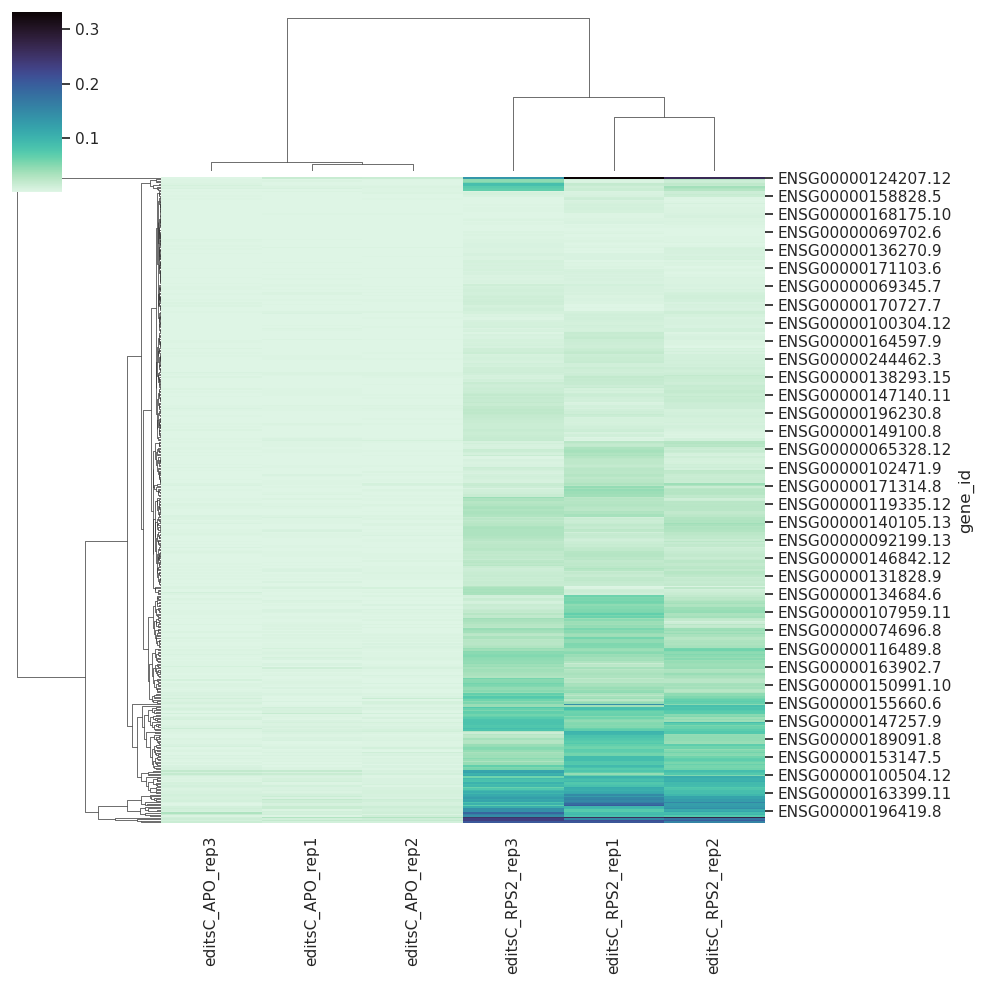

In [92]:
gene_editsC = make_heatmap(apo_gene_editsC, rps2_gene_editsC)

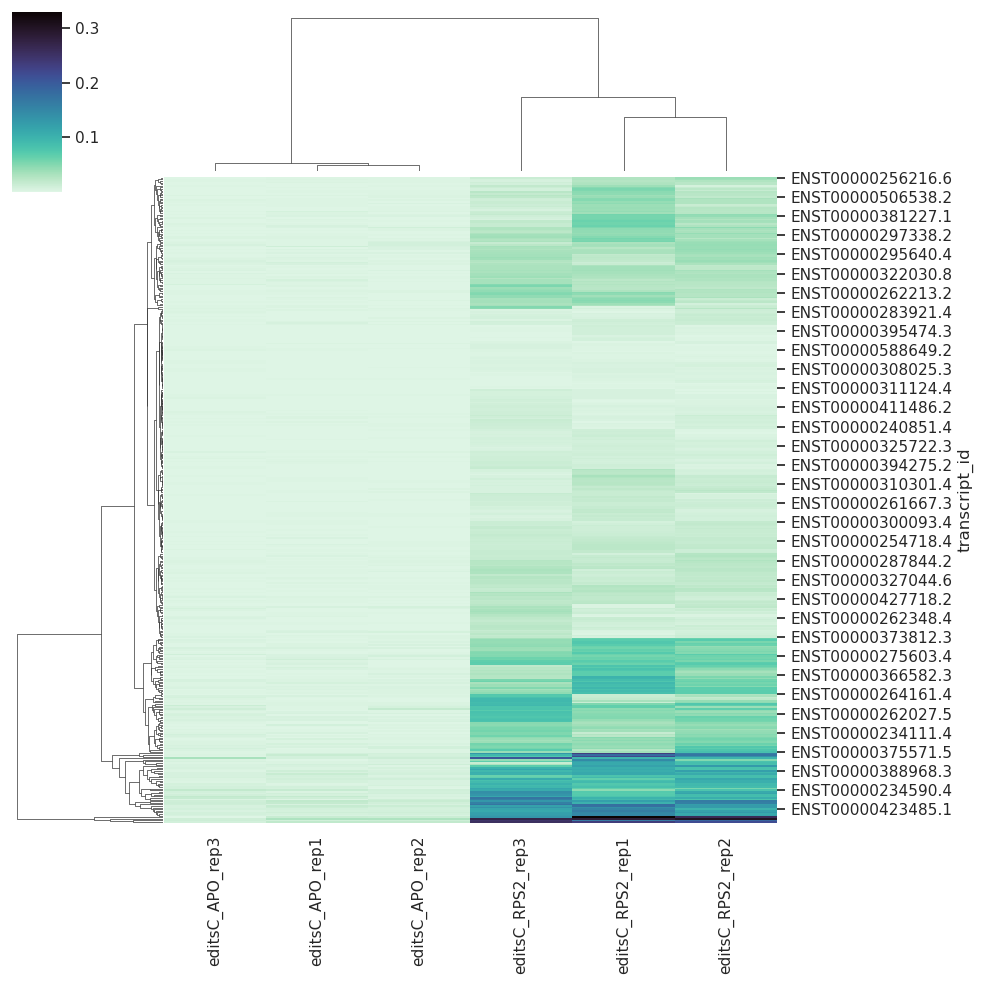

In [93]:
transcript_editsC = make_heatmap(apo_transcript_editsC, rps2_transcript_editsC)

In [120]:
def parse_gtf(gtf_file_path):
    '''Parse the GTF for information to annotate the gene level EditsC table with'''
    df_gtf = pd.read_csv(gtf_file_path, sep='\t', comment='#', header=None, names=['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute']) 
    df_gtf = df_gtf[df_gtf['feature'] == 'gene']
    df_gtf['gene_id'] = df_gtf['attribute'].str.extract('gene_id "([^"]+)"')
    df_gtf['gene_name'] = df_gtf['attribute'].str.extract('gene_name "([^"]+)"')
    df_gtf['gene_type'] = df_gtf['attribute'].str.extract('gene_type "([^"]+)"')
    df_genes = df_gtf[['gene_id', 'gene_name', 'gene_type']].set_index('gene_id') # Create a new DataFrame with just the gene ID, gene name, and gene type

    return df_genes

def annotate_dataframe(gene_editsC_df, gtf_file_path):
    '''Add the annotation to the gene level EditsC table'''
    df_genes_annotations = parse_gtf(gtf_file_path)
    annotated_df = gene_editsC_df.merge(df_genes_annotations, left_index=True, right_index=True, how='left')

    return annotated_df

In [121]:
def parse_gtf_for_transcripts(gtf_file_path):
    '''Parse the GTF for information to annotate the mRNA isoform level EditsC table with'''
    df_gtf = pd.read_csv(gtf_file_path, sep='\t', comment='#', header=None,names=['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'])
    df_gtf = df_gtf[df_gtf['feature'] == 'transcript']
    df_gtf['transcript_id'] = df_gtf['attribute'].str.extract('transcript_id "([^"]+)"')
    df_gtf['gene_name'] = df_gtf['attribute'].str.extract('gene_name "([^"]+)"')
    df_gtf['transcript_type'] = df_gtf['attribute'].str.extract('transcript_type "([^"]+)"')
    df_transcripts = df_gtf[['transcript_id', 'gene_name', 'transcript_type']].set_index('transcript_id') # Create a new DataFrame with just the transcript ID, gene name, and transcript type

    return df_transcripts

def annotate_dataframe_with_transcript_info(transcript_editsC_df, gtf_file_path):
    '''Add the annotation to the mRNA isoform level EditsC table'''
    df_transcripts = parse_gtf_for_transcripts(gtf_file_path)
    annotated_df = transcript_editsC_df.merge(df_transcripts, left_index=True, right_index=True, how='left')

    return annotated_df

In [122]:
def calculate_mean_apo(data):
    '''calculate the average EditsC for all replicates of APOBEC1-only'''
    return np.mean([data['editsC_APO_rep1'], data['editsC_APO_rep2'], data['editsC_APO_rep3']])

def calculate_mean_rps2(data):
    '''calculate the average EditsC for all replicates of Ribo-STAMP'''
    return np.mean([data['editsC_RPS2_rep1'], data['editsC_RPS2_rep2'], data['editsC_RPS2_rep3']])

In [123]:
annotated_gene_editsC = annotate_dataframe(gene_editsC, gtf_file)

In [125]:
annotated_gene_editsC['ensembl_gene_id'] = annotated_gene_editsC.apply(lambda x: x.name.split('.')[0], axis=1)

In [126]:
annotated_gene_editsC_copy = annotated_gene_editsC.copy()

In [128]:
# Add gene counts to the annotated EditsC table
for key in gene_counts:
    annotated_gene_editsC_copy = pd.concat([annotated_gene_editsC_copy, gene_counts[key].set_index('Geneid')], axis=1)

In [133]:
def add_zero_edits(df, metric):
    '''Account for genes that are expressed and have reads but are not edited'''
    if metric =='editsC':
        for rep in ['1', '2', '3']:
            df.loc[~df[f'APO1_{rep}'].isna() & df[f'editsC_APO_rep{rep}'].isna(), f'editsC_APO_rep{rep}'] = 0
            df.loc[~df[f'RPS2_{rep}'].isna()& df[f'editsC_RPS2_rep{rep}'].isna(), f'editsC_RPS2_rep{rep}'] = 0
        
    return df

In [134]:
annotated_gene_editsC_copy=add_zero_edits(annotated_gene_editsC_copy, 'editsC')

In [135]:
annotated_gene_editsC_copy['APO_mean'] = annotated_gene_editsC_copy.apply(calculate_mean_apo, axis=1)
annotated_gene_editsC_copy['RPS2_mean'] = annotated_gene_editsC_copy.apply(calculate_mean_rps2, axis=1)

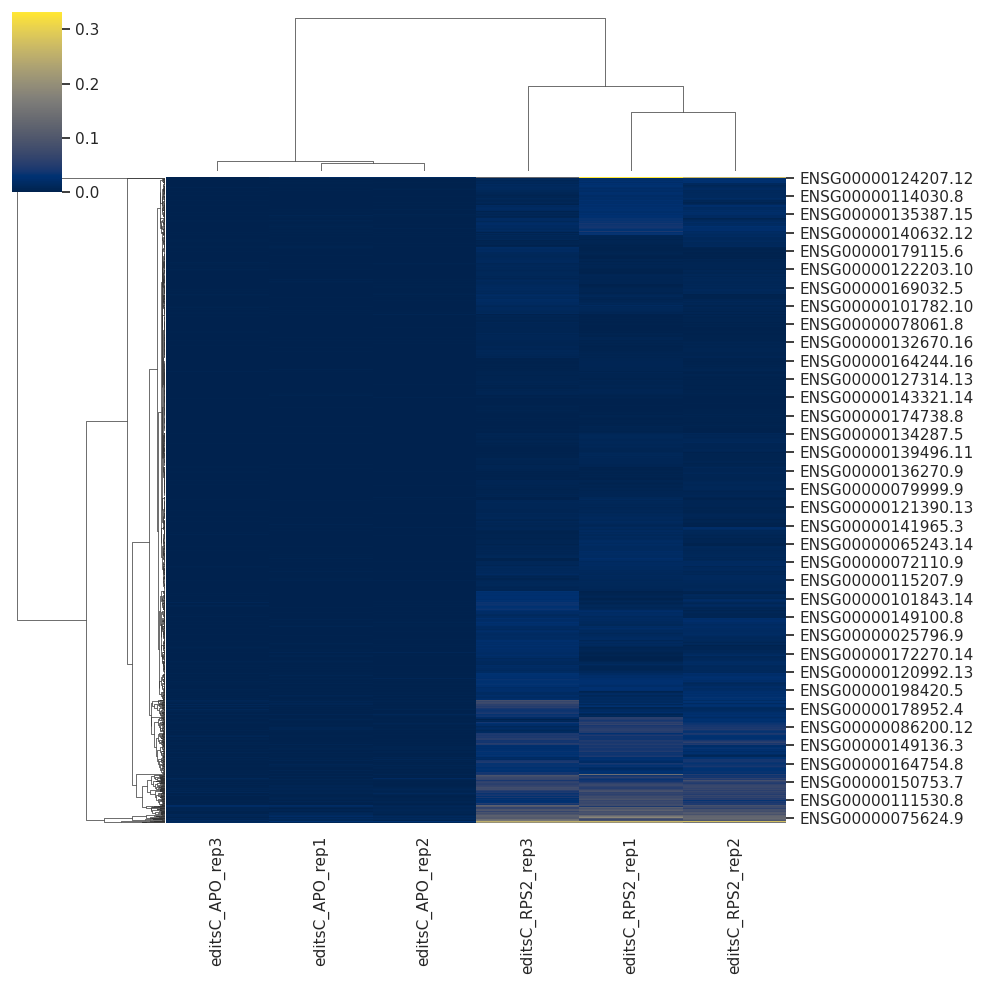

In [136]:
sns.clustermap(annotated_gene_editsC_copy[[i for i in annotated_gene_editsC_copy.columns if (('APO' in i) or ('RPS2' in i)) and ('editsC' in i) and ('rep' in i)]].dropna(), cmap='cividis')

In [137]:
annotated_gene_editsC_copy['APO_RPKM_mean'] = annotated_gene_editsC_copy.apply(lambda x: np.mean([x['APO1_1_RPKM'], x['APO1_2_RPKM'], x['APO1_3_RPKM']]), axis=1)
annotated_gene_editsC_copy['RPS2_RPKM_mean']= annotated_gene_editsC_copy.apply(lambda x: np.mean([x['RPS2_1_RPKM'], x['RPS2_2_RPKM'], x['RPS2_3_RPKM']]), axis=1)

## Correlation Analyses

### Replicate

In [139]:
from scipy import stats
import itertools

In [142]:
# Plot correlation of gene-level EditsC between replicates
sns.set_style('white')
def plot_rep_corelation(annotated_df, sample):
    '''Plot correlation between replicates'''
    fig, axes = plt.subplots(3,1, figsize=(5, 15))
    count=0
    for combo in list(itertools.combinations([f'editsC_{sample}_rep1',f'editsC_{sample}_rep2',f'editsC_{sample}_rep3'], 2)):
        rep1=combo[0]
        rep2=combo[1]
        print(rep1, rep2, stats.pearsonr(annotated_df[rep1].tolist(), annotated_df[rep2].tolist()))
        if sample=='APO':
            sns.scatterplot(data=annotated_df, x=rep1, y=rep2, ax=axes[count], linewidth=0, alpha=0.5, color='#028090')
            axes[count].text(0.025, 0.014, f'{stats.pearsonr(annotated_df[rep1].tolist(), annotated_df[rep2].tolist())[0]:.3f}')
        if sample=='RPS2':
            sns.scatterplot(data=annotated_df, x=rep1, y=rep2, ax=axes[count], linewidth=0, alpha=0.5, color='#FE9920')
            axes[count].text(0.25, 0.25, f'{stats.pearsonr(annotated_df[rep1].tolist(), annotated_df[rep2].tolist())[0]:.3f}')
        count+=1

editsC_APO_rep1 editsC_APO_rep2 PearsonRResult(statistic=0.704130204994009, pvalue=1.9370316681659654e-175)
editsC_APO_rep1 editsC_APO_rep3 PearsonRResult(statistic=0.5544538853676203, pvalue=4.989446384429619e-95)
editsC_APO_rep2 editsC_APO_rep3 PearsonRResult(statistic=0.5320660055269216, pvalue=2.808268850535312e-86)
editsC_RPS2_rep1 editsC_RPS2_rep2 PearsonRResult(statistic=0.9109596933958841, pvalue=0.0)
editsC_RPS2_rep1 editsC_RPS2_rep3 PearsonRResult(statistic=0.7528836430776937, pvalue=6.9657150879515094e-214)
editsC_RPS2_rep2 editsC_RPS2_rep3 PearsonRResult(statistic=0.85537050494454, pvalue=0.0)


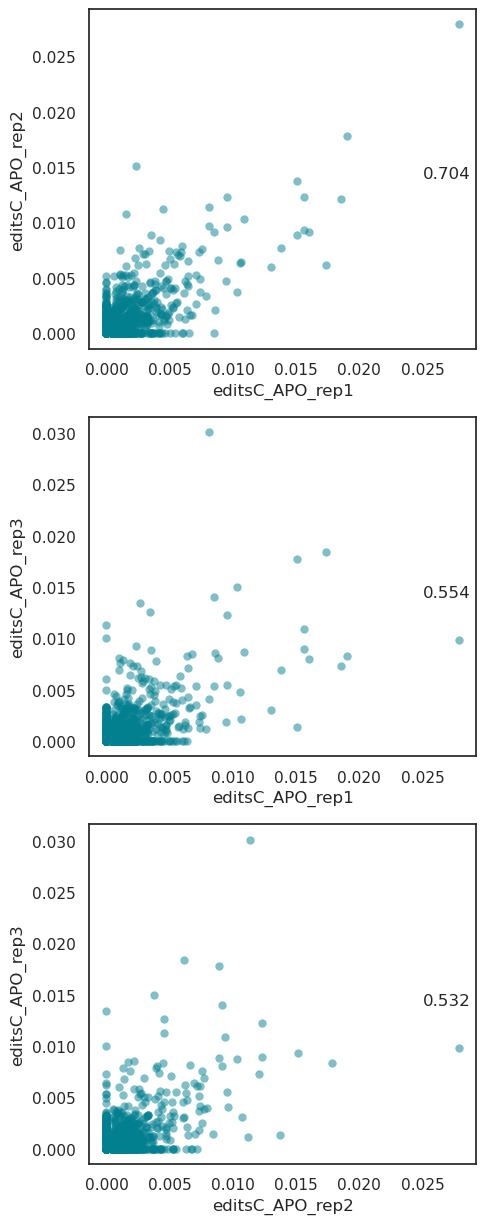

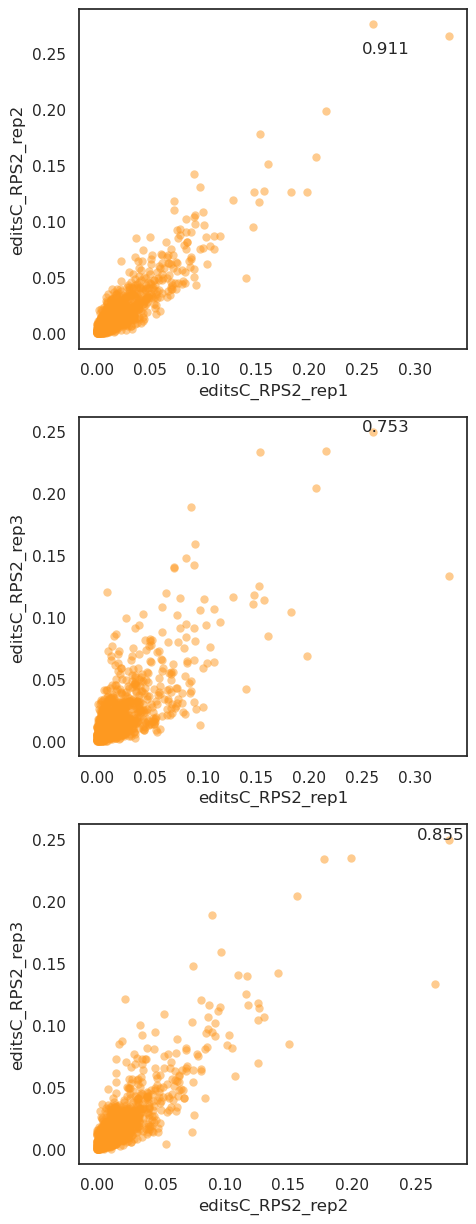

In [143]:
plot_rep_corelation(annotated_gene_editsC_copy.dropna(), 'APO')
plot_rep_corelation(annotated_gene_editsC_copy.dropna(), 'RPS2')

### Short-read

In [144]:
sr_epkm = pd.read_csv('/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/notebooks/RPS2/RPS2_STAMP_SR/epkm_outputs/epkm_6_epkms_merged/epkm.CDS.merged.tsv', sep='\t', index_col =0).iloc[:,:1].reset_index()

In [146]:
lr_sr_epkm_stamp = annotated_gene_editsC_copy.merge(sr_epkm, left_on='ensembl_gene_id', right_on='index').dropna()

SignificanceResult(statistic=0.40928994946700165, pvalue=2.360989730272661e-48)


Text(0.5, 0, 'Short-read Ribo-STAMP log10(EPKM)')

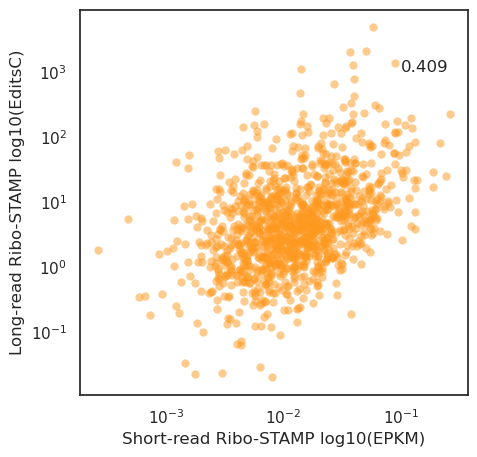

In [147]:
sns.scatterplot(data=lr_sr_epkm_stamp, x='RPS2_mean', y='RPS2-1000_S18_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam.epkm.CDS.extract.tsv', linewidth=0, alpha=0.5, color='#FE9920')
plt.text(0.1, 1000, f'{stats.spearmanr(lr_sr_epkm_stamp["RPS2_mean"], lr_sr_epkm_stamp["RPS2-1000_S18_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam.epkm.CDS.extract.tsv"])[0]:.3f}')
plt.yscale('log')
plt.xscale('log')
print(stats.spearmanr(lr_sr_epkm_stamp['RPS2_mean'], lr_sr_epkm_stamp['RPS2-1000_S18_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam.epkm.CDS.extract.tsv']))
plt.ylabel('Long-read Ribo-STAMP log10(EditsC)')
plt.xlabel('Short-read Ribo-STAMP log10(EPKM)')

### Mass Spectrometry

In [153]:
masspec_data = pd.read_csv(os.path.join('/tscc/nfs/home/pjaganna1/projects/STAMP/isoform_pipeline/masspec_hek/combined/txt', 'proteinGroups.txt'), sep='\t')
masspec_data_foranalysis = masspec_data[['Protein IDs', 'Peptide IDs', 'LFQ intensity SHegazi_WT1', 'LFQ intensity SHegazi_WT2', 'LFQ intensity SHegazi_WT3', 'LFQ intensity SHegazi_WT4']]

In [154]:
masspec_data_foranalysis['WT LFQ Average'] = masspec_data_foranalysis.apply(lambda x: np.mean([x['LFQ intensity SHegazi_WT1'], 
                                                                                               x['LFQ intensity SHegazi_WT2'], 
                                                                                               x['LFQ intensity SHegazi_WT3'],
                                                                                               x['LFQ intensity SHegazi_WT4']]), axis=1)

/tscc/projects/ps-yeolab3/pjaganna1/STAMP/github_repos/LR-Ribo-STAMP/publication_notebooks/APOBEC1-only_Ribo-STAMP_HEK293T/ipykernel_2183968/1752964394.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masspec_data_foranalysis['WT LFQ Average'] = masspec_data_foranalysis.apply(lambda x: np.mean([x['LFQ intensity SHegazi_WT1'],


In [155]:
masspec_data_foranalysis_cp = masspec_data_foranalysis.copy()

In [156]:
def get_protein_name(df):
    '''get the protein name for each mass spec entry'''
    protein_id = df['Protein IDs']
    if len(protein_id.split(';'))==1:
        if '_HUMAN' in protein_id:
            return protein_id.split('|')[2].strip('_HUMAN')
    else:
        return None
masspec_data_foranalysis['Protein Name'] = masspec_data_foranalysis.apply(get_protein_name, axis=1)

/tscc/projects/ps-yeolab3/pjaganna1/STAMP/github_repos/LR-Ribo-STAMP/publication_notebooks/APOBEC1-only_Ribo-STAMP_HEK293T/ipykernel_2183968/3980957492.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masspec_data_foranalysis['Protein Name'] = masspec_data_foranalysis.apply(get_protein_name, axis=1)


In [157]:
# keep only the ones with protein names
masspec_data_foranalysis = masspec_data_foranalysis.dropna(subset=['Protein Name'])

In [158]:
masspec_data_sorted=masspec_data_foranalysis.sort_values('WT LFQ Average', ascending=False)

In [159]:
# Merge Mass Spec data with long-read Ribo-STAMP data gene level EditsC
masspec_stamp_merge = annotated_gene_editsC_copy.merge(masspec_data_sorted, left_on='gene_name', right_on='Protein Name')

RPS2 SignificanceResult(statistic=0.40302938766855373, pvalue=7.529273285049298e-14)


Text(0.5, 0, 'Ribo-STAMP log10(EditsC)')

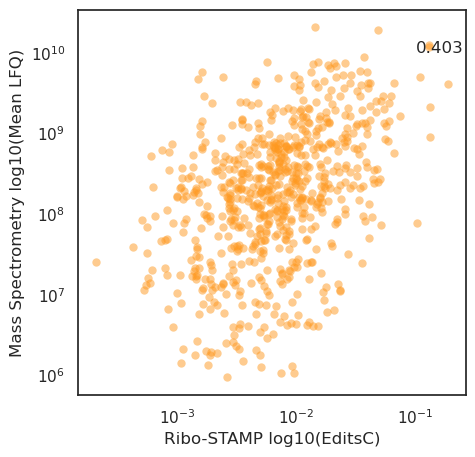

In [160]:
sns.scatterplot(data=masspec_stamp_merge, x='RPS2_mean', y='WT LFQ Average', linewidth=0, alpha=0.5, color='#FE9920')
print('RPS2', stats.spearmanr(masspec_stamp_merge.dropna()['RPS2_mean'], masspec_stamp_merge.dropna()['WT LFQ Average']))
plt.xscale('log')
plt.yscale('log')
plt.text(0.1, 10**10, f"{stats.spearmanr(masspec_stamp_merge.dropna()['RPS2_mean'], masspec_stamp_merge.dropna()['WT LFQ Average'])[0]:.3f}")
plt.ylabel('Mass Spectrometry log10(Mean LFQ)')
plt.xlabel('Ribo-STAMP log10(EditsC)')

## Gene level PCA

In [161]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [165]:
pca_annotated_gene_editsC_copy  = annotated_gene_editsC_copy[(annotated_gene_editsC_copy['APO_mean']!=0) &(annotated_gene_editsC_copy['RPS2_mean']!=0)]

In [166]:
pca_gene_rpkm = pca_annotated_gene_editsC_copy[[col for col in pca_annotated_gene_editsC_copy.columns if 'RPKM' in col and 'mean' not in col]].reset_index()
pca_gene_rpkm['new_index'] = pca_gene_rpkm.apply(lambda x: x['index'] + '_rpkm', axis=1)
pca_gene_rpkm=pca_gene_rpkm.rename(columns={key : f'{key.split("_")[0]}_rep{key.split("_")[1]}' for key in list(pca_gene_rpkm.columns)[1:7]})
pca_gene_rpkm = pca_gene_rpkm.set_index('new_index')


In [167]:
pca_gene_editsC = pca_annotated_gene_editsC_copy[[col for col in pca_annotated_gene_editsC_copy.columns if 'editsC' in col and 'mean' not in col]].reset_index()
pca_gene_editsC['new_index'] = pca_gene_editsC.apply(lambda x: x['index'] + '_editsC', axis=1)
pca_gene_editsC=pca_gene_editsC.rename(columns={key : f'{key.split("_")[1]}_{key.split("_")[2]}' for key in list(pca_gene_editsC.columns)[1:7]})
pca_gene_editsC=pca_gene_editsC.rename(columns={'APO_rep1':'APO1_rep1', 'APO_rep2':'APO1_rep2', 'APO_rep3':'APO1_rep3'})
pca_gene_editsC = pca_gene_editsC.set_index('new_index')


In [168]:
def generate_pca_plot(df):
    pca_df = df.dropna().drop(columns=['index']).T
    pca_df_colnames = pca_df.columns
    scaler = StandardScaler()
    data_standardized = scaler.fit_transform(pca_df)
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data_standardized)
    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
    pca_df = pca_df.reset_index()
    plt.figure(figsize=(5,5))
    plt.scatter(principal_components[:3, 0], principal_components[:3, 1], c='#028090')
    plt.scatter(principal_components[3:, 0], principal_components[3:, 1], c='#FE9920')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0] * 100:.2f}%)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1] * 100:.2f}%)')
    plt.title('PCA Plot')
    plt.show()

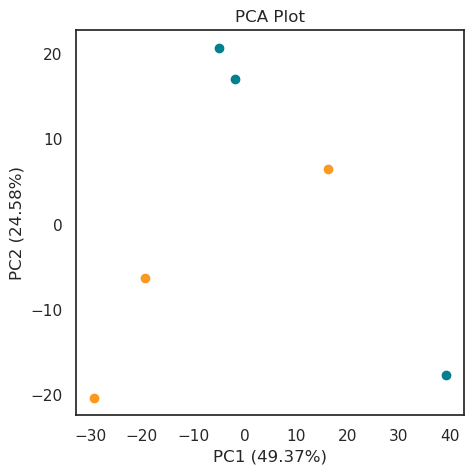

In [169]:
# PCA based on gene-level expression (RPKM)
generate_pca_plot(pca_gene_rpkm)

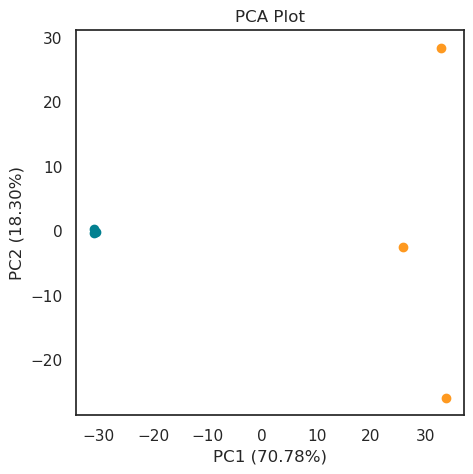

In [170]:
# PCA based on gene-level translation (EditsC)
generate_pca_plot(pca_gene_editsC)

## Linear Regression (Gene Level)

In [173]:
import statsmodels.api as sm

In [174]:
annotated_gene_editsC_copy_lm = annotated_gene_editsC_copy.copy().dropna()

In [175]:
X = sm.add_constant(annotated_gene_editsC_copy_lm['APO_mean'])  # adding a constant for the intercept
y = annotated_gene_editsC_copy_lm['RPS2_mean']

# Fit a linear regression model using APO_mean as the predictor and RPS2_mean as the response variable
model_linear = sm.OLS(y, X).fit()

# Calculate the residuals
annotated_gene_editsC_copy_lm['residuals'] = model_linear.resid

# Identify significant residuals
# For this example, let's consider residuals that are greater than 1 standard deviation from the mean as significant
mean_residual = annotated_gene_editsC_copy_lm['residuals'].mean()
std_residual = annotated_gene_editsC_copy_lm['residuals'].std()
threshold = mean_residual + std_residual

# Find data points where the signal is significantly greater than the background
significant_signal = annotated_gene_editsC_copy_lm[annotated_gene_editsC_copy_lm['residuals'] > threshold]

# Display the results
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              RPS2_mean   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     2408.
Date:                Wed, 14 Feb 2024   Prob (F-statistic):          9.20e-286
Time:                        18:11:20   Log-Likelihood:                 3311.2
No. Observations:                1167   AIC:                            -6618.
Df Residuals:                    1165   BIC:                            -6608.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0059      0.001     11.625      0.000       0.005       0.007
APO_mean      10.9163      0.222     49.069      0.000      10.480      11.353
==============================================================================
Omnibus:                      438.081   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6275.976
Skew:                           1.328   Prob(JB):                         0.00
Kurtosis:                      14.046   Cond. No.                         536.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [178]:
# Assign sig label based on thresholding on residual
annotated_gene_editsC_copy_lm['sig'] = annotated_gene_editsC_copy_lm['gene_name'].isin(significant_signal['gene_name'].tolist())

/tscc/projects/ps-yeolab3/pjaganna1/STAMP/github_repos/LR-Ribo-STAMP/publication_notebooks/APOBEC1-only_Ribo-STAMP_HEK293T/ipykernel_2183968/357723526.py:4: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.scatterplot(x='APO_mean', y='RPS2_mean', data=annotated_gene_editsC_copy_lm, palette=custom_palette, linewidth=0, alpha=0.5, hue='sig')


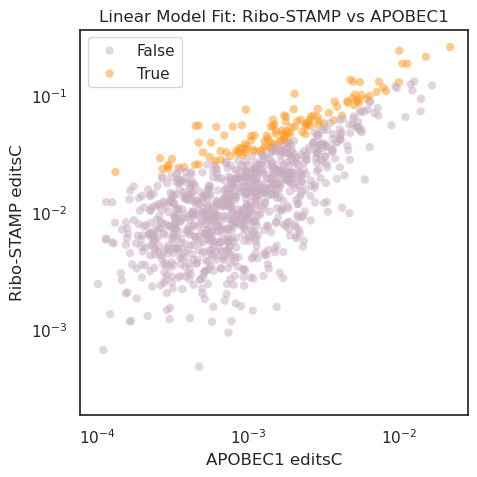

In [180]:
# Plotting the results from linear regression
sns.set(rc={'figure.figsize':(5,5)})
sns.set_style('white')
sns.scatterplot(x='APO_mean', y='RPS2_mean', data=annotated_gene_editsC_copy_lm, palette=custom_palette, linewidth=0, alpha=0.5, hue='sig')

predicted_values = model_linear.predict(X) # Predicted values from the linear model

plt.title('Linear Model Fit: Ribo-STAMP vs APOBEC1')
plt.xlabel('APOBEC1 editsC')
plt.ylabel('Ribo-STAMP editsC')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [181]:
annotated_transcript_editsC = annotate_dataframe_with_transcript_info(transcript_editsC, gtf_file)

In [182]:
for key in transcript_counts:
    annotated_transcript_editsC = pd.concat([annotated_transcript_editsC, transcript_counts[key]], axis=1)

In [183]:
def add_zero_edits_transcript(df):
    '''Accounting for mRNA isoforms expressed but not edited'''
    for rep in ['1', '2', '3']:
        df.loc[~df[f'APO1_{rep}_count'].isna() & df[f'editsC_APO_rep{rep}'].isna(), f'editsC_APO_rep{rep}'] = 0
        df.loc[~df[f'RPS2_{rep}_count'].isna()& df[f'editsC_RPS2_rep{rep}'].isna(), f'editsC_RPS2_rep{rep}'] = 0 
    return df

In [184]:
add_zero_edits_transcript(annotated_transcript_editsC)

,editsC_APO_rep1,editsC_APO_rep2,editsC_APO_rep3,editsC_RPS2_rep1,editsC_RPS2_rep2,editsC_RPS2_rep3,gene_name,transcript_type,APO1_1_count,Length,...,APO1_2_RPKM,RPS2_2_count,Length,RPS2_2_RPKM,APO1_3_count,Length,APO1_3_RPKM,RPS2_3_count,Length,RPS2_3_RPKM
transcript_id,,,,,,,,,,,,,,,,,,,,,
ENST00000000412.3,0.001131,0.000000,0.000000,0.004525,0.006787,0.001131,M6PR,protein_coding,34.0,9590.0,...,16.016290,31.0,9590.0,19.855615,35.0,9590.0,25.364239,35.0,9590.0,19.479889
ENST00000001008.4,0.001520,0.001520,0.003040,0.027356,0.028875,0.027356,FKBP4,protein_coding,113.0,9005.0,...,69.539142,47.0,9005.0,32.059327,122.0,9005.0,94.156113,88.0,9005.0,52.159808
ENST00000002165.6,0.002924,0.001462,0.000000,0.004386,0.017544,0.021930,FUCA2,protein_coding,45.0,16879.0,...,13.999756,30.0,16879.0,10.917289,46.0,16879.0,18.940155,63.0,16879.0,19.921905
ENST00000005340.5,0.000650,0.000000,0.001951,0.000650,0.001951,0.005202,DVL2,protein_coding,23.0,9204.0,...,16.046140,NaN,NaN,NaN,34.0,9204.0,25.672887,43.0,9204.0,24.936120
ENST00000008527.5,0.002125,0.000000,0.000000,0.019129,0.012752,0.011690,CRY1,protein_coding,75.0,102465.0,...,2.767406,69.0,102465.0,4.136317,27.0,102465.0,1.831305,73.0,102465.0,3.802632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENST00000266458.5,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0,10323.0,13.960304
ENST00000398073.2,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,26812.0,4.976773
ENST00000268483.3,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,8798.0,12.133415


In [185]:
annotated_transcript_editsC['APO_mean'] = annotated_transcript_editsC.apply(calculate_mean_apo, axis=1)

In [186]:
annotated_transcript_editsC['RPS2_mean'] = annotated_transcript_editsC.apply(calculate_mean_rps2, axis=1)

In [187]:
annotated_transcript_editsC['shortened_transcript_id'] = annotated_transcript_editsC.apply(lambda x: x.name.split('.')[0], axis=1)

In [188]:
annotated_transcript_editsC['APO_RPKM_mean'] = annotated_transcript_editsC.apply(lambda x: np.mean([x['APO1_1_RPKM'], x['APO1_2_RPKM'], x['APO1_3_RPKM']]), axis=1)
annotated_transcript_editsC['RPS2_RPKM_mean']= annotated_transcript_editsC.apply(lambda x: np.mean([x['RPS2_1_RPKM'], x['RPS2_2_RPKM'], x['RPS2_3_RPKM']]), axis=1)

<Axes: xlabel='RPS2_mean', ylabel='Count'>

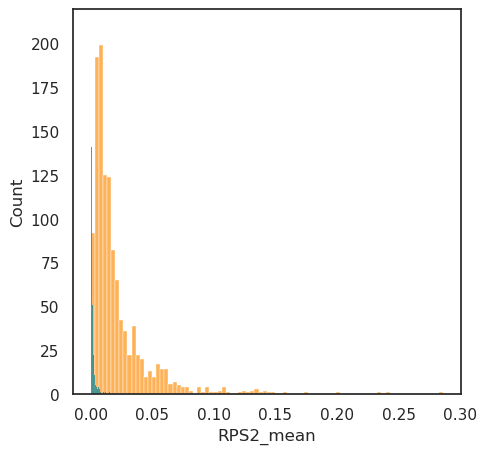

In [190]:
# Visualizing differences in distribution of mRNA isoform EditsC in APOBEC1-only and Ribo-STAMP
sns.set(rc={'figure.figsize':(5,5)})
sns.set_style('white')
sns.histplot(annotated_transcript_editsC.dropna()['RPS2_mean'], color='#FE9920')
sns.histplot(annotated_transcript_editsC.dropna()['APO_mean'], color='#028090')

SignificanceResult(statistic=-0.18254484033200677, pvalue=1.7572949737612857e-10)


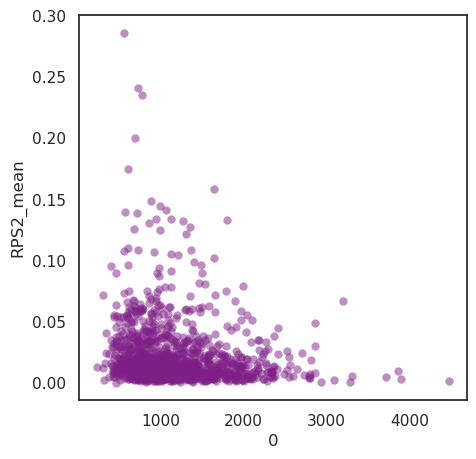

SignificanceResult(statistic=-0.16272339419474036, pvalue=1.3603049477413015e-08)


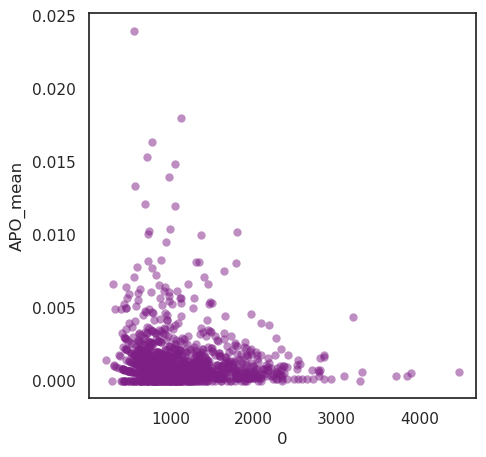

In [196]:
# Visualizing the relationship between mRNA isoform EditC and the number of cytosines in associated with an isoform
for e in ['RPS2_mean', 'APO_mean']:
    transcript_edits_cs = pd.DataFrame.from_dict(transcript_cytosine_counts, orient='index').merge(annotated_transcript_editsC.dropna()[[e]], left_index=True, right_index=True)
    sns.scatterplot(data=transcript_edits_cs, y=e, x=0, linewidth=0, alpha=0.5, color='#7E1F86')
    print(stats.spearmanr(transcript_edits_cs[0], transcript_edits_cs[e]))
    plt.show()

### Genes with multiple isoforms represented

In [218]:
# find how many genes have mutliple isoforms expressed
transcripts_per_gene_df = pd.DataFrame(annotated_transcript_editsC.dropna()['gene_name'].value_counts())

In [219]:
multiple_transcript_genes = transcripts_per_gene_df[transcripts_per_gene_df['count'] ==2].index.tolist()

In [220]:
multiple_transcript_genes_df = annotated_transcript_editsC[annotated_transcript_editsC.gene_name.isin(multiple_transcript_genes)].dropna().sort_values(by='gene_name')

In [221]:
multiple_transcript_genes_df = multiple_transcript_genes_df.sort_values(by=['gene_name', 'RPS2_mean'], ascending=[True, False])

In [222]:
 multiple_transcript_genes_df = multiple_transcript_genes_df[multiple_transcript_genes_df.duplicated(subset='gene_name', keep='first') | multiple_transcript_genes_df.duplicated(subset='gene_name',keep='last')]

In [223]:
multiple_transcript_genes_df['iso_group'] = ['A', 'B']* int(multiple_transcript_genes_df.shape[0]/2)

In [224]:
multiple_transcript_genes_df = multiple_transcript_genes_df[multiple_transcript_genes_df['iso_group']=='A'].merge(multiple_transcript_genes_df[multiple_transcript_genes_df['iso_group']=='B'], on='gene_name', suffixes=['_A', '_B']).set_index('gene_name')

In [225]:
multiple_transcript_genes_df_cols = [i for i in multiple_transcript_genes_df.columns if 'editsC' in i]

In [226]:
multiple_transcript_genes_df_toplot = multiple_transcript_genes_df[multiple_transcript_genes_df_cols[:3] + multiple_transcript_genes_df_cols[6:9] + multiple_transcript_genes_df_cols[3:6]  + multiple_transcript_genes_df_cols[9:]]

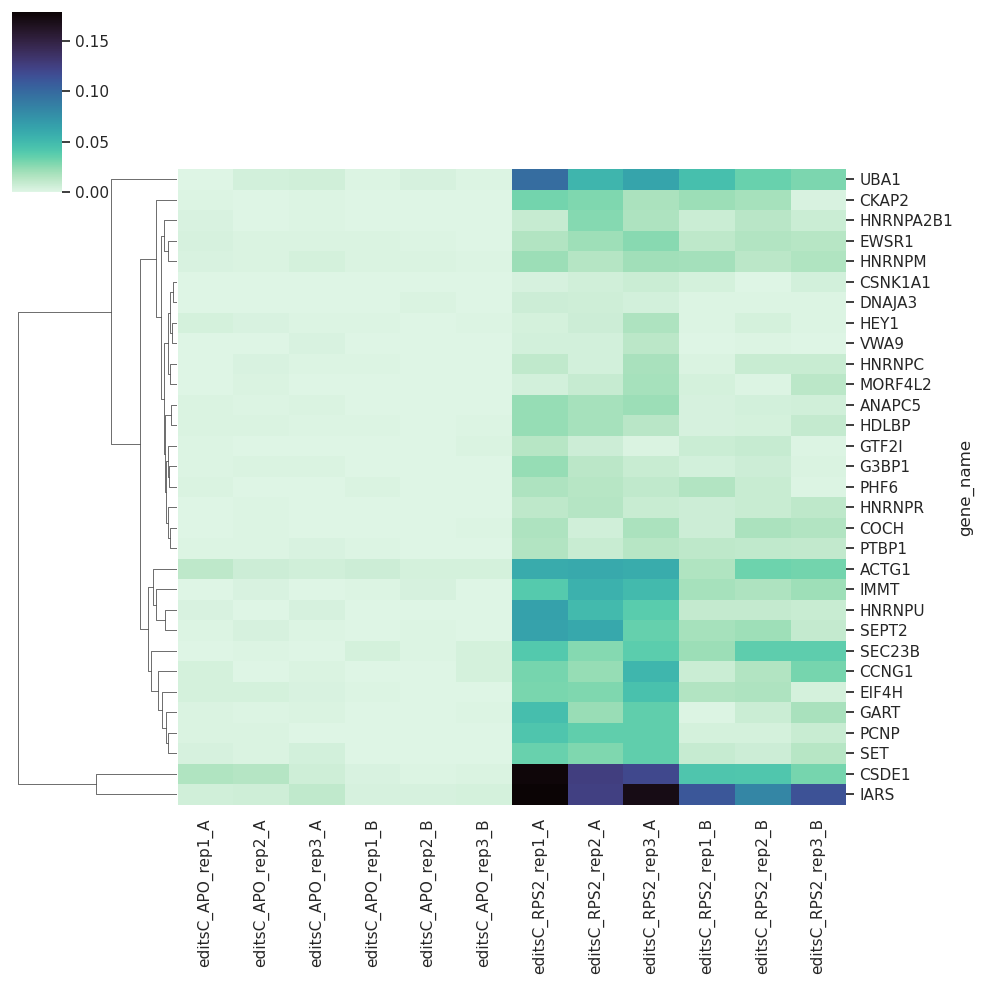

In [227]:
sns.clustermap(data=multiple_transcript_genes_df[multiple_transcript_genes_df_cols[:3] + multiple_transcript_genes_df_cols[6:9] + multiple_transcript_genes_df_cols[3:6]  + multiple_transcript_genes_df_cols[9:]], col_cluster=False, cmap='mako_r')


## PCA analysis mRNA isoform level

In [198]:
annotated_transcript_editsC_copy = annotated_transcript_editsC.copy()

In [199]:
pca_annotated_transcript_editsC_copy  = annotated_transcript_editsC_copy[(annotated_transcript_editsC_copy['APO_mean']!=0) &(annotated_transcript_editsC_copy['RPS2_mean']!=0)]

In [201]:
pca_transcript_rpkm = pca_annotated_transcript_editsC_copy[[col for col in pca_annotated_transcript_editsC_copy.columns if 'RPKM' in col and 'mean' not in col]].reset_index()
pca_transcript_rpkm['new_index'] = pca_transcript_rpkm.apply(lambda x: x['transcript_id'] + '_rpkm', axis=1)
pca_transcript_rpkm=pca_transcript_rpkm.rename(columns={key : f'{key.split("_")[0]}_rep{key.split("_")[1]}' for key in list(pca_transcript_rpkm.columns)[1:7]})
pca_transcript_rpkm = pca_transcript_rpkm.set_index('new_index')

In [202]:
pca_transcript_editsC = pca_annotated_transcript_editsC_copy[[col for col in pca_annotated_transcript_editsC_copy.columns if 'editsC' in col and 'mean' not in col]].reset_index()
pca_transcript_editsC['new_index'] = pca_transcript_editsC.apply(lambda x: x['transcript_id'] + '_editsC', axis=1)
pca_transcript_editsC=pca_transcript_editsC.rename(columns={key : f'{key.split("_")[1]}_{key.split("_")[2]}' for key in list(pca_transcript_editsC.columns)[1:7]})
pca_transcript_editsC=pca_transcript_editsC.rename(columns={'APO_rep1':'APO1_rep1', 'APO_rep2':'APO1_rep2', 'APO_rep3':'APO1_rep3'})
pca_transcript_editsC = pca_transcript_editsC.set_index('new_index')

In [208]:
def generate_pca_plot_transcript(df):
    '''PCA analysis for mRNA isoform'''
    pca_df = df.dropna().drop(columns=['transcript_id']).T
    pca_df_colnames = pca_df.columns
    scaler = StandardScaler()
    data_standardized = scaler.fit_transform(pca_df)
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data_standardized)
    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
    pca_df = pca_df.reset_index()
    plt.figure(figsize=(5,5))
    plt.scatter(principal_components[:3, 0], principal_components[:3, 1], c='#028090')
    plt.scatter(principal_components[3:, 0], principal_components[3:, 1], c='#FE9920')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0] * 100:.2f}%)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1] * 100:.2f}%)')
    plt.title('PCA Plot')
    plt.show()

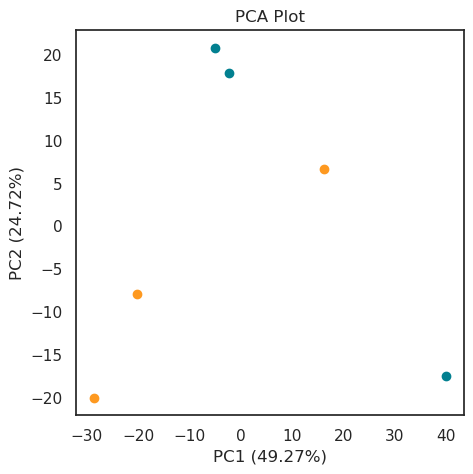

In [209]:
generate_pca_plot_transcript(pca_transcript_rpkm)

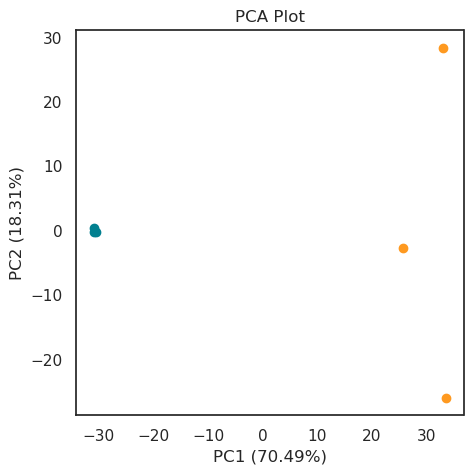

In [210]:
generate_pca_plot_transcript(pca_transcript_editsC)

## Linear Regression (mRNA isoform level)

In [211]:
annotated_transcript_editsC_lm = annotated_transcript_editsC.copy().dropna()

In [212]:
X_transcript = sm.add_constant(annotated_transcript_editsC_lm['APO_mean'])  # adding a constant for the intercept
y_transcript = annotated_transcript_editsC_lm['RPS2_mean']

# Fit a linear regression model using APO_mean as the predictor and RPS2_mean as the response variable
model_linear_transcript = sm.OLS(y_transcript, X_transcript).fit()

# Calculate the residuals
annotated_transcript_editsC_lm['residuals'] = model_linear_transcript.resid

# Identify significant residuals
# For this example, let's consider residuals that are greater than 1 standard deviation from the mean as significant
mean_residual_transcript = annotated_transcript_editsC_lm['residuals'].mean()
std_residual_transcript = annotated_transcript_editsC_lm['residuals'].std()
threshold_transcript = mean_residual_transcript + std_residual_transcript

# Find data points where the signal is significantly greater than the background
significant_signal_transcript = annotated_transcript_editsC_lm[annotated_transcript_editsC_lm['residuals'] > threshold]

# Display the results
model_linear_transcript.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              RPS2_mean   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     2398.
Date:                Wed, 14 Feb 2024   Prob (F-statistic):          1.41e-288
Time:                        18:24:27   Log-Likelihood:                 3324.0
No. Observations:                1204   AIC:                            -6644.
Df Residuals:                    1202   BIC:                            -6634.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0065      0.001     12.092      0.000       0.005       0.008
APO_mean      10.9756      0.224     48.967      0.000      10.536      11.415
==============================================================================
Omnibus:                      447.517   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5190.935
Skew:                           1.379   Prob(JB):                         0.00
Kurtosis:                      12.791   Cond. No.                         508.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [213]:
annotated_transcript_editsC_lm['sig'] = annotated_transcript_editsC_lm['gene_name'].isin(significant_signal_transcript['gene_name'].tolist())

/tscc/projects/ps-yeolab3/pjaganna1/STAMP/github_repos/LR-Ribo-STAMP/publication_notebooks/APOBEC1-only_Ribo-STAMP_HEK293T/ipykernel_2183968/948167832.py:3: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.scatterplot(x='APO_mean', y='RPS2_mean', data=annotated_transcript_editsC_lm, palette=custom_palette, linewidth=0, alpha=0.5, hue='sig')


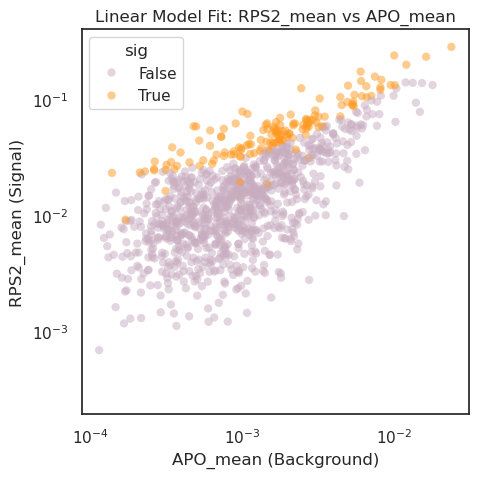

In [216]:
sns.set(rc={'figure.figsize':(5,5)})
sns.set_style('white')
sns.scatterplot(x='APO_mean', y='RPS2_mean', data=annotated_transcript_editsC_lm, palette=custom_palette, linewidth=0, alpha=0.5, hue='sig')
predicted_values_transcript = model_linear_transcript.predict(X)

plt.title('Linear Model Fit: RPS2_mean vs APO_mean')
plt.xlabel('APO_mean (Background)')
plt.ylabel('RPS2_mean (Signal)')
plt.xscale('log')
plt.yscale('log')
plt.show()